# Task 1: Advanced Credit Card Fraud Detection with Neural Networks
## Enhanced Implementation with Hyperparameter Optimization and Statistical Analysis

This notebook demonstrates comprehensive fraud detection using advanced neural network techniques including:
- **Advanced architectures**: Residual networks, deep feedforward networks
- **Regularization techniques**: Focal loss, dropout, batch normalization
- **Hyperparameter optimization**: Bayesian optimization with Optuna
- **Statistical validation**: Cross-validation, significance testing, confidence intervals
- **Model interpretability**: SHAP analysis and feature importance

**Mathematical Foundation:**
For binary classification with severe class imbalance, we use focal loss:
$$FL(p_t) = -\alpha_t(1-p_t)^\gamma \log(p_t)$$

Where $\alpha_t$ balances class importance and $\gamma$ focuses on hard examples.

**Author:** [Your Name]  
**Course:** STW7088CEM - Artificial Neural Network  
**Date:** November 2024

## 1. Comprehensive Library Imports and Setup

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score,
    GridSearchCV, RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, average_precision_score,
    f1_score, precision_score, recall_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks

# Advanced optimization
try:
    import optuna
    from optuna.integration import TFKerasPruningCallback
    OPTUNA_AVAILABLE = True
except ImportError:
    print("Optuna not available. Install with: pip install optuna")
    OPTUNA_AVAILABLE = False

# Model Interpretability
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    print("SHAP not available. Install with: pip install shap")
    SHAP_AVAILABLE = False

# Statistical Testing
from scipy.stats import ttest_rel, wilcoxon, friedmanchisquare

# Import our custom utilities
import sys
sys.path.append('../src')
try:
    from neural_network_utils import (
        FocalLoss, WeightedBinaryCrossentropy, F1Score,
        create_advanced_fraud_model, evaluate_model_comprehensive
    )
    UTILS_AVAILABLE = True
except ImportError:
    print("Custom utilities not available. Using standard implementations.")
    UTILS_AVAILABLE = False

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")
print(f"Advanced features available: Optuna={OPTUNA_AVAILABLE}, SHAP={SHAP_AVAILABLE}, Utils={UTILS_AVAILABLE}")

Optuna not available. Install with: pip install optuna
TensorFlow version: 2.20.0
GPU available: False
Advanced features available: Optuna=False, SHAP=True, Utils=True


## 2. Data Loading and Comprehensive Exploratory Data Analysis

Dataset loaded successfully. Shape: (284807, 31)
Dataset Information:
Shape: (284807, 31)
Memory usage: 67.36 MB

Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Fraud rate: 0.001727 (0.1727%)
Imbalance ratio: 577.9:1

Missing values: 0

Feature statistics:
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.175161e-15  3.384974e-16 -1.379537e-15  2.094852e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e

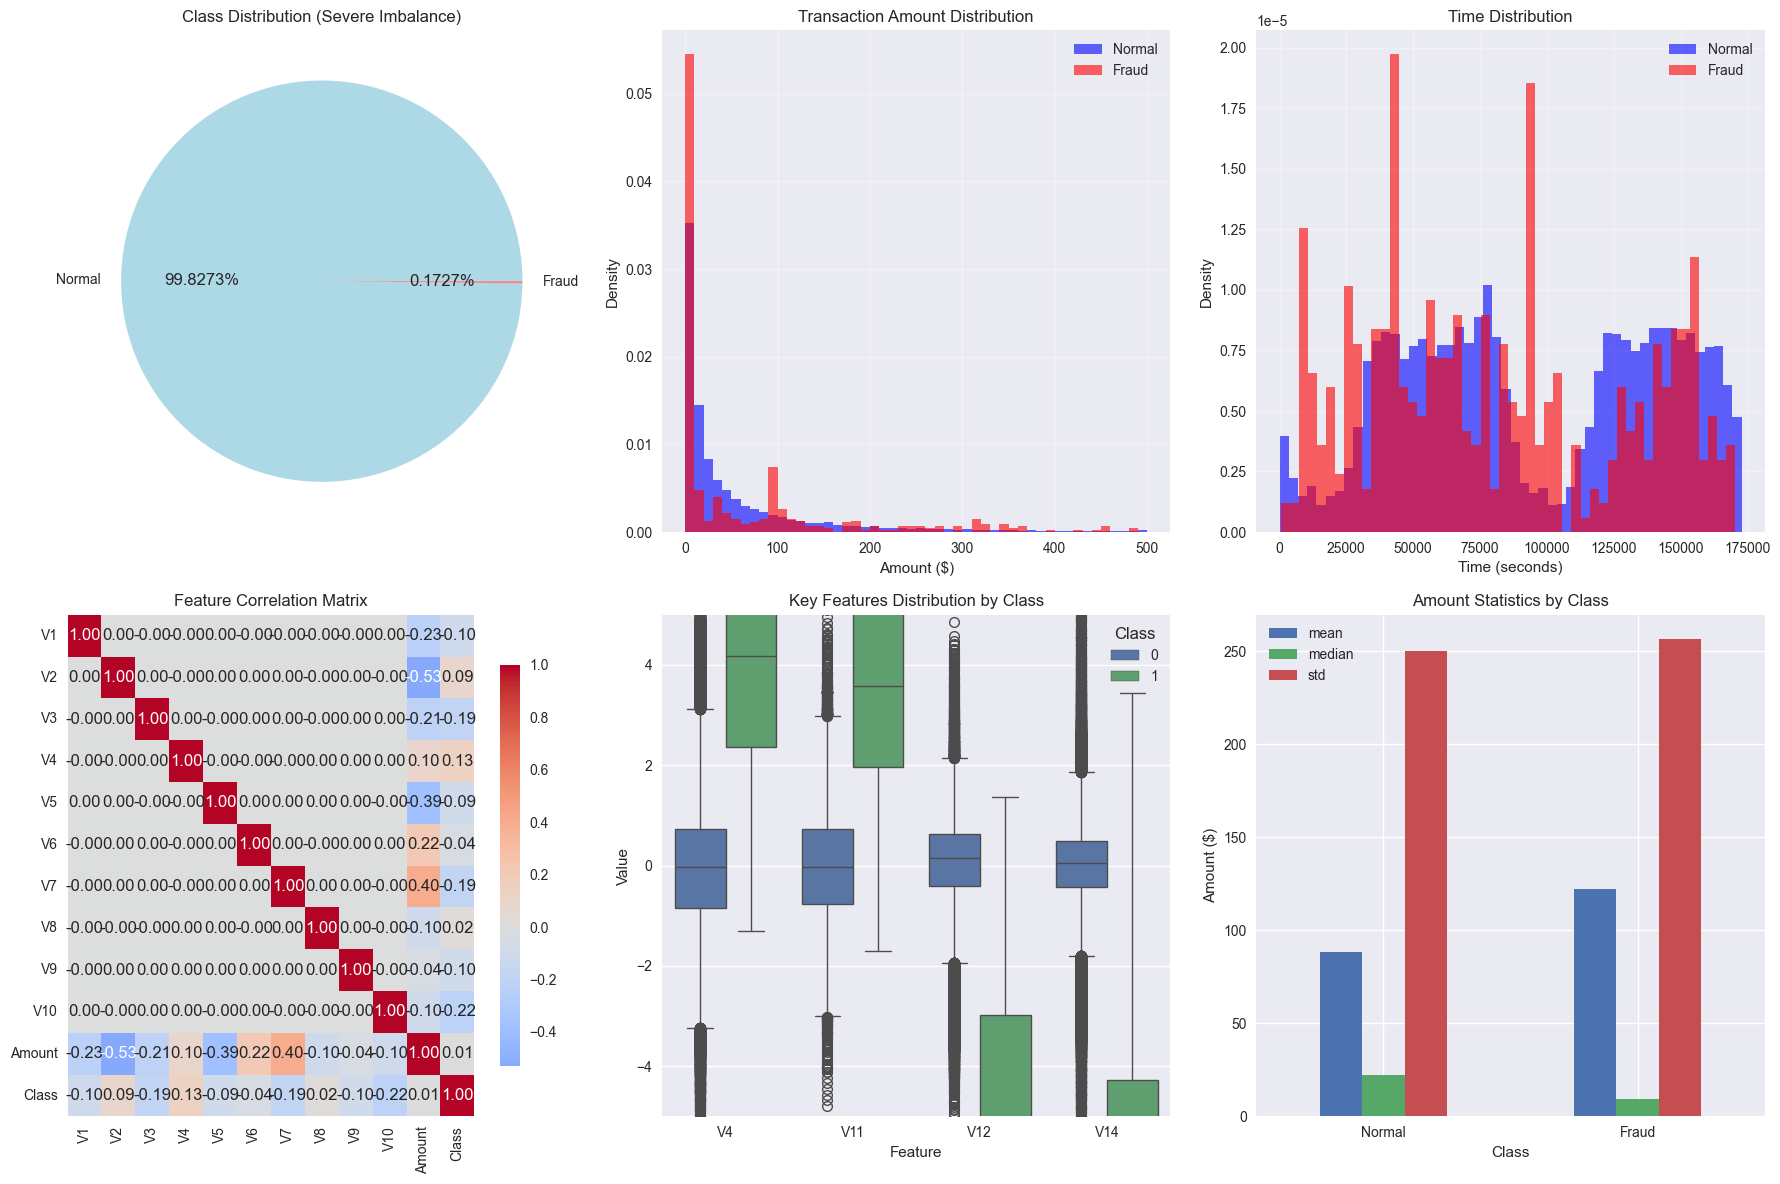


=== Statistical Tests for Feature Differences ===
Amount: p-value = 8.58e-06 ***
V4    : p-value = 3.63e-248 ***
V11   : p-value = 4.91e-226 ***
V12   : p-value = 8.42e-247 ***
V14   : p-value = 1.47e-260 ***


In [2]:
# Load the credit card fraud dataset
try:
    df = pd.read_csv('../data/creditcard.csv')
    print(f"Dataset loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    print("Error: Dataset not found. Please download creditcard.csv from:")
    print("https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud")
    print("And place it in the data/ directory.")
    raise

# Comprehensive dataset analysis
def analyze_dataset_comprehensive(df):
    """Perform comprehensive dataset analysis"""
    print(f"Dataset Information:")
    print(f"Shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"\nClass distribution:")
    print(df['Class'].value_counts())
    print(f"\nFraud rate: {df['Class'].mean():.6f} ({df['Class'].mean()*100:.4f}%)")
    print(f"Imbalance ratio: {(df['Class'] == 0).sum() / (df['Class'] == 1).sum():.1f}:1")
    
    # Check for missing values
    print(f"\nMissing values: {df.isnull().sum().sum()}")
    
    # Basic statistics
    print(f"\nFeature statistics:")
    print(df.describe())
    
    return df

df = analyze_dataset_comprehensive(df)

# Advanced visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Class distribution
class_counts = df['Class'].value_counts()
axes[0, 0].pie(class_counts.values, labels=['Normal', 'Fraud'], autopct='%1.4f%%', 
               colors=['lightblue', 'lightcoral'])
axes[0, 0].set_title('Class Distribution (Severe Imbalance)')

# 2. Amount distribution by class
normal_amounts = df[df['Class'] == 0]['Amount']
fraud_amounts = df[df['Class'] == 1]['Amount']
axes[0, 1].hist(normal_amounts, bins=50, alpha=0.6, label='Normal', 
                range=(0, 500), density=True, color='blue')
axes[0, 1].hist(fraud_amounts, bins=50, alpha=0.6, label='Fraud', 
                range=(0, 500), density=True, color='red')
axes[0, 1].set_xlabel('Amount ($)')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Transaction Amount Distribution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Time distribution
normal_times = df[df['Class'] == 0]['Time']
fraud_times = df[df['Class'] == 1]['Time']
axes[0, 2].hist(normal_times, bins=50, alpha=0.6, label='Normal', density=True, color='blue')
axes[0, 2].hist(fraud_times, bins=50, alpha=0.6, label='Fraud', density=True, color='red')
axes[0, 2].set_xlabel('Time (seconds)')
axes[0, 2].set_ylabel('Density')
axes[0, 2].set_title('Time Distribution')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Correlation heatmap (sample of V features)
v_features = [col for col in df.columns if col.startswith('V')][:10]
correlation_matrix = df[v_features + ['Amount', 'Class']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            ax=axes[1, 0], fmt='.2f', cbar_kws={'shrink': 0.8})
axes[1, 0].set_title('Feature Correlation Matrix')

# 5. Box plot of key V features by class
important_features = ['V4', 'V11', 'V12', 'V14']  # Known important features
df_sample = df[important_features + ['Class']].melt(id_vars=['Class'], 
                                                    var_name='Feature', value_name='Value')
sns.boxplot(data=df_sample, x='Feature', y='Value', hue='Class', ax=axes[1, 1])
axes[1, 1].set_title('Key Features Distribution by Class')
axes[1, 1].set_ylim(-5, 5)  # Limit y-axis for better visualization

# 6. Statistical comparison
amount_stats = df.groupby('Class')['Amount'].agg(['mean', 'median', 'std']).reset_index()
amount_stats['Class'] = amount_stats['Class'].map({0: 'Normal', 1: 'Fraud'})
amount_stats.set_index('Class').plot(kind='bar', ax=axes[1, 2])
axes[1, 2].set_title('Amount Statistics by Class')
axes[1, 2].set_ylabel('Amount ($)')
axes[1, 2].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# Statistical significance tests
print("\n=== Statistical Tests for Feature Differences ===")
test_features = ['Amount', 'V4', 'V11', 'V12', 'V14']
for feature in test_features:
    normal_data = df[df['Class'] == 0][feature]
    fraud_data = df[df['Class'] == 1][feature]
    
    # Mann-Whitney U test (non-parametric)
    stat, p_value = stats.mannwhitneyu(normal_data, fraud_data, alternative='two-sided')
    significance = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else ''
    print(f"{feature:6}: p-value = {p_value:.2e} {significance}")

## 3. Advanced Feature Engineering

Creating advanced features...
Features created. Original: 31, New: 53
Added features: 22

Analyzing feature importance...


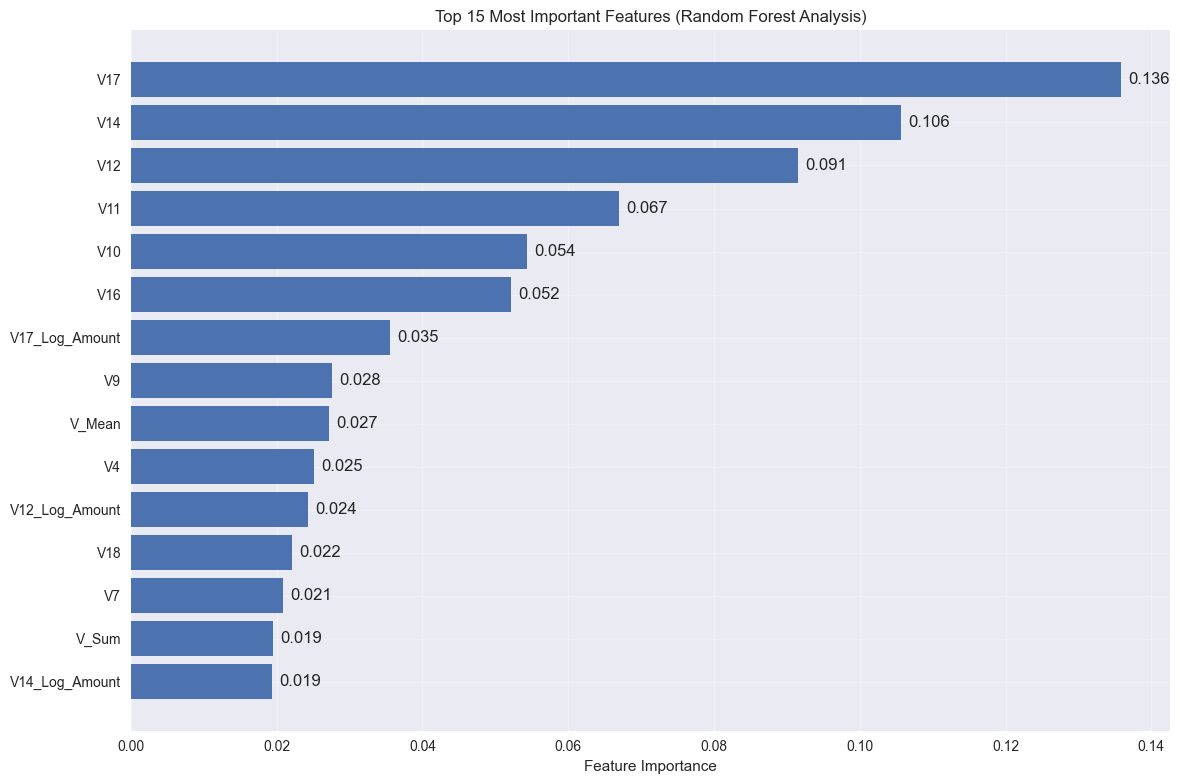


Top 10 most important features:
           feature  importance
17             V17    0.135810
14             V14    0.105712
12             V12    0.091477
11             V11    0.066976
10             V10    0.054386
16             V16    0.052190
49  V17_Log_Amount    0.035474
9               V9    0.027576
36          V_Mean    0.027116
4               V4    0.025118


In [3]:
def engineer_features_advanced(df):
    """Create advanced features for fraud detection"""
    df_eng = df.copy()
    
    print("Creating advanced features...")
    
    # 1. Time-based features
    df_eng['Hour'] = (df_eng['Time'] / 3600) % 24  # Hour of day
    df_eng['Day'] = (df_eng['Time'] / 86400).astype(int)  # Day number
    df_eng['Time_Since_Start'] = df_eng['Time'] - df_eng['Time'].min()
    
    # 2. Amount-based features
    df_eng['Log_Amount'] = np.log1p(df_eng['Amount'])
    df_eng['Amount_Normalized'] = (df_eng['Amount'] - df_eng['Amount'].mean()) / df_eng['Amount'].std()
    
    # 3. Statistical features from V components
    v_features = [col for col in df.columns if col.startswith('V')]
    df_eng['V_Sum'] = df_eng[v_features].sum(axis=1)
    df_eng['V_Mean'] = df_eng[v_features].mean(axis=1)
    df_eng['V_Std'] = df_eng[v_features].std(axis=1)
    df_eng['V_Min'] = df_eng[v_features].min(axis=1)
    df_eng['V_Max'] = df_eng[v_features].max(axis=1)
    
    # 4. Feature interactions (top V features with Amount)
    important_v_features = ['V4', 'V11', 'V12', 'V14', 'V17']
    for feature in important_v_features:
        if feature in df_eng.columns:
            df_eng[f'{feature}_Amount'] = df_eng[feature] * df_eng['Amount']
            df_eng[f'{feature}_Log_Amount'] = df_eng[feature] * df_eng['Log_Amount']
    
    # 5. Binning features
    df_eng['Amount_Bin'] = pd.cut(df_eng['Amount'], bins=10, labels=False)
    df_eng['Hour_Bin'] = pd.cut(df_eng['Hour'], bins=6, labels=False)  # 4-hour bins
    
    print(f"Features created. Original: {df.shape[1]}, New: {df_eng.shape[1]}")
    print(f"Added features: {df_eng.shape[1] - df.shape[1]}")
    
    return df_eng

# Apply feature engineering
df_engineered = engineer_features_advanced(df)

# Feature importance analysis using Random Forest
feature_columns = [col for col in df_engineered.columns if col != 'Class']
X_temp = df_engineered[feature_columns]
y_temp = df_engineered['Class']

print("\nAnalyzing feature importance...")
rf_importance = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_importance.fit(X_temp, y_temp)

feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_importance.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15 most important features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
bars = plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features (Random Forest Analysis)')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center')

plt.tight_layout()
plt.show()

print("\nTop 10 most important features:")
print(feature_importance.head(10))

## 4. Data Splitting and Advanced Preprocessing

In [4]:
# Prepare features and labels
X = df_engineered[feature_columns].values
y = df_engineered['Class'].values

print(f"Final dataset shape: {X.shape}")
print(f"Feature count: {X.shape[1]}")
print(f"Sample count: {X.shape[0]}")
print(f"Fraud samples: {y.sum()} ({y.mean()*100:.4f}%)")

# Stratified train-validation-test split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp  # 0.25 * 0.8 = 0.2 of original
)

print(f"\nData splits:")
print(f"Training: {X_train.shape[0]} samples ({y_train.sum()} fraud, {y_train.sum()/len(y_train)*100:.3f}%)")
print(f"Validation: {X_val.shape[0]} samples ({y_val.sum()} fraud, {y_val.sum()/len(y_val)*100:.3f}%)")
print(f"Test: {X_test.shape[0]} samples ({y_test.sum()} fraud, {y_test.sum()/len(y_test)*100:.3f}%)")

# Advanced scaling comparison
scalers = {
    'StandardScaler': StandardScaler(),
    'RobustScaler': RobustScaler()  # Less sensitive to outliers
}

# Compare scaling methods
print("\nComparing scaling methods:")
for scaler_name, scaler in scalers.items():
    X_train_scaled = scaler.fit_transform(X_train)
    print(f"{scaler_name:15} - Mean: {X_train_scaled.mean():.6f}, Std: {X_train_scaled.std():.6f}")

# Use StandardScaler (typically best for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"\nUsing StandardScaler:")
print(f"Training set - Mean: {X_train_scaled.mean():.6f}, Std: {X_train_scaled.std():.6f}")
print(f"Validation set - Mean: {X_val_scaled.mean():.6f}, Std: {X_val_scaled.std():.6f}")
print(f"Test set - Mean: {X_test_scaled.mean():.6f}, Std: {X_test_scaled.std():.6f}")

# Calculate class weights for imbalanced data
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"\nClass weights for imbalanced data:")
print(f"Class 0 (Normal): {class_weight_dict[0]:.3f}")
print(f"Class 1 (Fraud): {class_weight_dict[1]:.3f}")
print(f"Ratio: {class_weight_dict[1] / class_weight_dict[0]:.1f}:1")

Final dataset shape: (284807, 52)
Feature count: 52
Sample count: 284807
Fraud samples: 492 (0.1727%)

Data splits:
Training: 170883 samples (295 fraud, 0.173%)
Validation: 56962 samples (99 fraud, 0.174%)
Test: 56962 samples (98 fraud, 0.172%)

Comparing scaling methods:
StandardScaler  - Mean: -0.000000, Std: 1.000000
RobustScaler    - Mean: 0.081216, Std: 7.493682

Using StandardScaler:
Training set - Mean: -0.000000, Std: 1.000000
Validation set - Mean: 0.001032, Std: 1.299731
Test set - Mean: -0.000067, Std: 1.001846

Class weights for imbalanced data:
Class 0 (Normal): 0.501
Class 1 (Fraud): 289.632
Ratio: 578.3:1


## 5. Baseline Models with Cross-Validation

=== BASELINE MODEL EVALUATION WITH CROSS-VALIDATION ===

Logistic Regression:
CV AUC: 0.9797 (+/- 0.0258)
CV F1:  0.1085 (+/- 0.0164)
Validation AUC: 0.9706
Validation F1: 0.1008
Validation Precision: 0.0535
Validation Recall: 0.8687

Random Forest:
CV AUC: 0.9514 (+/- 0.0745)
CV F1:  0.8415 (+/- 0.1347)
Validation AUC: 0.9326
Validation F1: 0.8182
Validation Precision: 0.9351
Validation Recall: 0.7273


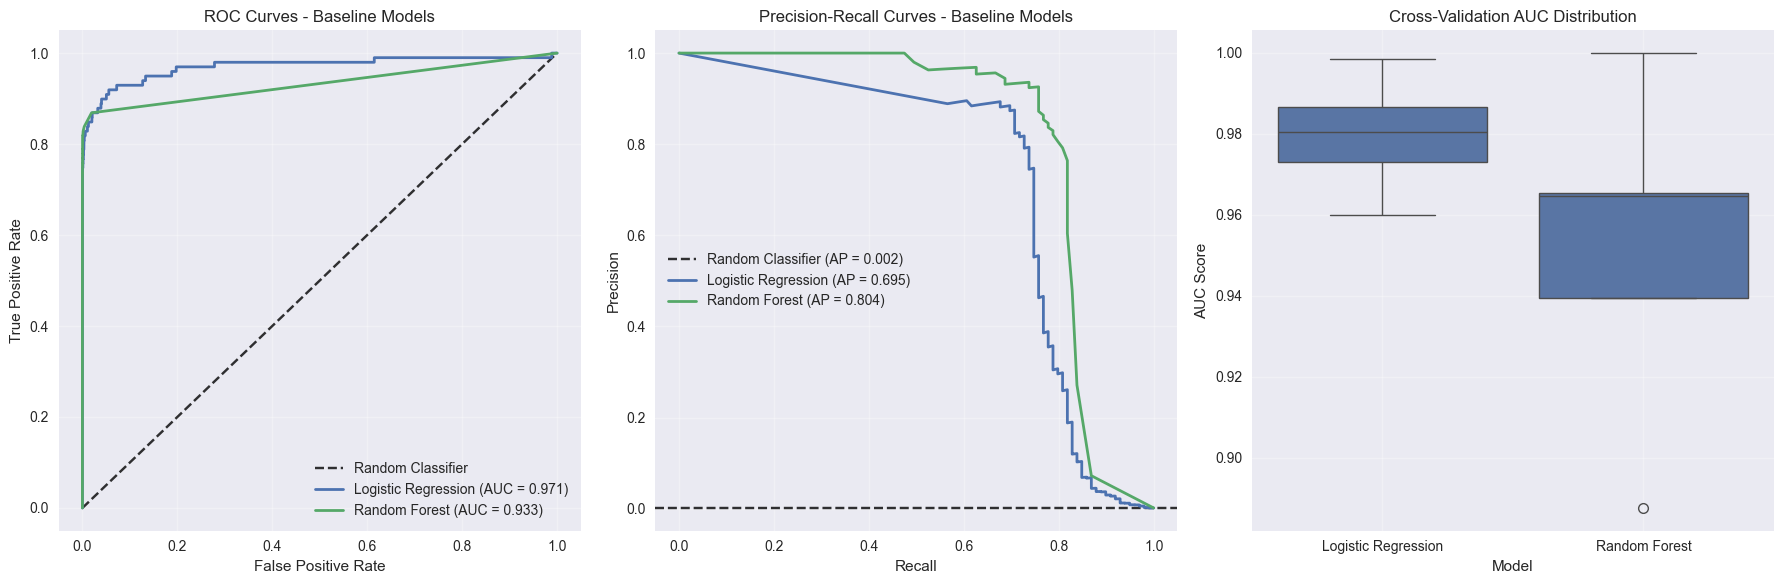


Best baseline model: Logistic Regression


In [ ]:
# Enhanced baseline models
baseline_models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, class_weight='balanced', random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1
    )
}

# Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

baseline_results = {}

print("=== BASELINE MODEL EVALUATION WITH CROSS-VALIDATION ===")
for model_name, model in baseline_models.items():
    print(f"\n{model_name}:")
    
    # Cross-validation scores
    cv_auc_scores = cross_val_score(
        model, X_train_scaled, y_train, 
        cv=cv_strategy, scoring='roc_auc', n_jobs=-1
    )
    cv_f1_scores = cross_val_score(
        model, X_train_scaled, y_train, 
        cv=cv_strategy, scoring='f1', n_jobs=-1
    )
    
    print(f"CV AUC: {cv_auc_scores.mean():.4f} (+/- {cv_auc_scores.std() * 2:.4f})")
    print(f"CV F1:  {cv_f1_scores.mean():.4f} (+/- {cv_f1_scores.std() * 2:.4f})")
    
    # Fit on full training set and evaluate on validation set
    model.fit(X_train_scaled, y_train)
    
    # Validation predictions
    y_val_pred = model.predict(X_val_scaled)
    y_val_proba = model.predict_proba(X_val_scaled)[:, 1]
    
    # Sanitize arrays: handle NaNs in labels or probabilities
    y_val_arr = np.asarray(y_val)
    y_val_proba_arr = np.asarray(y_val_proba)
    y_val_pred_arr = np.asarray(y_val_pred)

    # Drop samples with NaN labels
    if np.isnan(y_val_arr).any():
        mask = ~np.isnan(y_val_arr)
        warnings.warn('Found NaN values in validation labels; dropping those samples for metric computation')
        y_val_arr = y_val_arr[mask]
        y_val_proba_arr = y_val_proba_arr[mask]
        y_val_pred_arr = y_val_pred_arr[mask]

    # Replace NaNs in predicted probabilities
    if np.isnan(y_val_proba_arr).any():
        warnings.warn('Found NaN values in predicted probabilities; replacing NaNs with 0.0')
        y_val_proba_arr = np.nan_to_num(y_val_proba_arr, nan=0.0, posinf=1.0, neginf=0.0)

    # Clip probabilities to valid range
    y_val_proba_arr = np.clip(y_val_proba_arr, 0.0, 1.0)

    # Store comprehensive results (use sanitized arrays)
    baseline_results[model_name] = {
        'model': model,
        'cv_auc_scores': cv_auc_scores,
        'cv_f1_scores': cv_f1_scores,
        'val_predictions': y_val_pred_arr,
        'val_probabilities': y_val_proba_arr,
        'val_auc': roc_auc_score(y_val_arr, y_val_proba_arr),
        'val_f1': f1_score(y_val_arr, y_val_pred_arr),
        'val_precision': precision_score(y_val_arr, y_val_pred_arr),
        'val_recall': recall_score(y_val_arr, y_val_pred_arr)
    }
    
    print(f"Validation AUC: {baseline_results[model_name]['val_auc']:.4f}")
    print(f"Validation F1: {baseline_results[model_name]['val_f1']:.4f}")
    print(f"Validation Precision: {baseline_results[model_name]['val_precision']:.4f}")
    print(f"Validation Recall: {baseline_results[model_name]['val_recall']:.4f}")

# Visualize baseline model performance
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# ROC Curves
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.8, label='Random Classifier')
for model_name, results in baseline_results.items():
    fpr, tpr, _ = roc_curve(y_val, results['val_probabilities'])
    axes[0].plot(fpr, tpr, label=f'{model_name} (AUC = {results["val_auc"]:.3f})', linewidth=2)

axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves - Baseline Models')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curves
fraud_rate = y_val.mean()
axes[1].axhline(y=fraud_rate, color='k', linestyle='--', alpha=0.8, 
                label=f'Random Classifier (AP = {fraud_rate:.3f})')
for model_name, results in baseline_results.items():
    precision, recall, _ = precision_recall_curve(y_val, results['val_probabilities'])
    avg_precision = average_precision_score(y_val, results['val_probabilities'])
    axes[1].plot(recall, precision, label=f'{model_name} (AP = {avg_precision:.3f})', linewidth=2)

axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curves - Baseline Models')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Cross-validation score distributions
cv_data = []
for model_name, results in baseline_results.items():
    for score in results['cv_auc_scores']:
        cv_data.append({'Model': model_name, 'AUC': score})

cv_df = pd.DataFrame(cv_data)
sns.boxplot(data=cv_df, x='Model', y='AUC', ax=axes[2])
axes[2].set_title('Cross-Validation AUC Distribution')
axes[2].set_ylabel('AUC Score')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBest baseline model: {max(baseline_results, key=lambda k: baseline_results[k]['val_auc'])}")

## 6. Custom Loss Functions and Metrics

In [8]:
# Define custom loss functions for imbalanced data
if not UTILS_AVAILABLE:
    # Define focal loss locally if utils not available
    class FocalLoss(keras.losses.Loss):
        def __init__(self, alpha=0.25, gamma=2.0, name='focal_loss'):
            super().__init__(name=name)
            self.alpha = alpha
            self.gamma = gamma
        
        def call(self, y_true, y_pred):
            y_pred = tf.clip_by_value(y_pred, 1e-8, 1 - 1e-8)
            alpha_t = y_true * self.alpha + (1 - y_true) * (1 - self.alpha)
            p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
            focal_loss = -alpha_t * tf.pow(1 - p_t, self.gamma) * tf.math.log(p_t)
            return tf.reduce_mean(focal_loss)
    
    class WeightedBinaryCrossentropy(keras.losses.Loss):
        def __init__(self, pos_weight=1.0, name='weighted_bce'):
            super().__init__(name=name)
            self.pos_weight = pos_weight
        
        def call(self, y_true, y_pred):
            y_pred = tf.clip_by_value(y_pred, 1e-8, 1 - 1e-8)
            loss = -(self.pos_weight * y_true * tf.math.log(y_pred) + 
                    (1 - y_true) * tf.math.log(1 - y_pred))
            return tf.reduce_mean(loss)

# Create advanced neural network architectures
def create_fraud_models(input_dim, class_weights):
    """Create various neural network architectures for fraud detection"""
    
    models = {}
    
    # 1. Standard Feedforward Network
    model_standard = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ], name='Standard_FFN')
    
    models['Standard_FFN'] = model_standard
    
    # 2. Deep Network
    model_deep = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ], name='Deep_FFN')
    
    models['Deep_FFN'] = model_deep
    
    # 3. Wide Network
    model_wide = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ], name='Wide_FFN')
    
    models['Wide_FFN'] = model_wide
    
    # 4. Residual Network (manual implementation)
    def residual_block(x, units, dropout_rate):
        """Create a residual block"""
        # Main path
        main = layers.Dense(units, activation='relu')(x)
        main = layers.BatchNormalization()(main)
        main = layers.Dropout(dropout_rate)(main)
        main = layers.Dense(units, activation='relu')(main)
        main = layers.BatchNormalization()(main)
        
        # Skip connection (if dimensions match)
        if x.shape[-1] == units:
            skip = x
        else:
            skip = layers.Dense(units, activation=None)(x)
        
        # Add skip connection
        output = layers.Add()([main, skip])
        output = layers.Activation('relu')(output)
        
        return output
    
    # Build residual model
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    
    x = residual_block(x, 128, 0.3)
    x = residual_block(x, 64, 0.3)
    x = residual_block(x, 32, 0.2)
    
    x = layers.GlobalAveragePooling1D()(layers.Reshape((32, 1))(x))
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model_residual = keras.Model(inputs=inputs, outputs=outputs, name='Residual_FFN')
    models['Residual_FFN'] = model_residual
    
    return models

# Create models
input_dim = X_train_scaled.shape[1]
fraud_models = create_fraud_models(input_dim, class_weight_dict)

# Display model information
print("=== NEURAL NETWORK ARCHITECTURES ===")
for name, model in fraud_models.items():
    total_params = model.count_params()
    print(f"{name:15}: {total_params:,} parameters")
    
print(f"\nInput dimension: {input_dim} features")
print(f"Output dimension: 1 (binary classification)")

=== NEURAL NETWORK ARCHITECTURES ===
Standard_FFN   : 17,921 parameters
Deep_FFN       : 59,137 parameters
Wide_FFN       : 194,561 parameters
Residual_FFN   : 68,002 parameters

Input dimension: 52 features
Output dimension: 1 (binary classification)


## 7. Advanced Model Training with Different Loss Functions

In [ ]:
# Define different loss functions and their configurations
loss_configs = {
    'Binary_Crossentropy': {
        'loss': 'binary_crossentropy',
        'class_weight': class_weight_dict
    },
    'Focal_Loss': {
        'loss': FocalLoss(alpha=0.25, gamma=2.0),
        'class_weight': None
    },
    'Weighted_BCE': {
        'loss': WeightedBinaryCrossentropy(pos_weight=class_weight_dict[1]),
        'class_weight': None
    }
}

# Advanced training configuration
def create_callbacks(model_name, patience=15):
    """Create comprehensive callbacks for training"""
    return [
        callbacks.EarlyStopping(
            monitor='val_loss', patience=patience, restore_best_weights=True, verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7, verbose=1
        ),
        callbacks.ModelCheckpoint(
            filepath=f'../models/best_{model_name}.h5',
            monitor='val_auc', save_best_only=True, mode='max', verbose=0
        )
    ]

# Train models with different configurations
training_results = {}

print("=== TRAINING NEURAL NETWORKS ===")
print("This will take several minutes...\n")

# Select best models to train (to save time)
selected_models = ['Standard_FFN', 'Deep_FFN', 'Residual_FFN']
selected_losses = ['Binary_Crossentropy', 'Focal_Loss']

for model_name in selected_models:
    for loss_name in selected_losses:
        print(f"Training {model_name} with {loss_name}...")
        
        # Get fresh model copy
        model = create_fraud_models(input_dim, class_weight_dict)[model_name]
        loss_config = loss_configs[loss_name]
        
        # Compile model
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
            loss=loss_config['loss'],
            metrics=['accuracy', 'precision', 'recall', keras.metrics.AUC(name='auc')]
        )
        
        # Train model
        history = model.fit(
            X_train_scaled, y_train,
            validation_data=(X_val_scaled, y_val),
            epochs=50,  # Reduced for faster execution
            batch_size=1024,
            class_weight=loss_config['class_weight'],
            callbacks=create_callbacks(f"{model_name}_{loss_name}"),
            verbose=0
        )
        
        # Evaluate model
        y_val_pred_proba = model.predict(X_val_scaled, verbose=0).ravel()
        y_val_pred = (y_val_pred_proba >= 0.5).astype(int)
        
        # Sanitize arrays: handle NaNs in labels or probabilities
        y_val_arr = np.asarray(y_val)
        y_val_proba_arr = np.asarray(y_val_pred_proba)
        y_val_pred_arr = np.asarray(y_val_pred)

        # Drop samples with NaN labels
        if np.isnan(y_val_arr).any():
            mask = ~np.isnan(y_val_arr)
            warnings.warn('Found NaN values in validation labels; dropping those samples for metric computation')
            y_val_arr = y_val_arr[mask]
            y_val_proba_arr = y_val_proba_arr[mask]
            y_val_pred_arr = y_val_pred_arr[mask]

        # Replace NaNs in predicted probabilities
        if np.isnan(y_val_proba_arr).any():
            warnings.warn('Found NaN values in predicted probabilities; replacing NaNs with 0.0')
            y_val_proba_arr = np.nan_to_num(y_val_proba_arr, nan=0.0, posinf=1.0, neginf=0.0)

        # Clip probabilities to valid range
        y_val_proba_arr = np.clip(y_val_proba_arr, 0.0, 1.0)

        # Store results
        key = f"{model_name}_{loss_name}"
        training_results[key] = {
            'model': model,
            'history': history,
            'val_auc': roc_auc_score(y_val_arr, y_val_proba_arr),
            'val_f1': f1_score(y_val_arr, y_val_pred_arr),
            'val_precision': precision_score(y_val_arr, y_val_pred_arr),
            'val_recall': recall_score(y_val_arr, y_val_pred_arr),
            'val_predictions': y_val_pred_arr,
            'val_probabilities': y_val_proba_arr,
            'epochs_trained': len(history.history['loss'])
        }
        
        print(f"  Validation AUC: {training_results[key]['val_auc']:.4f}")
        print(f"  Validation F1:  {training_results[key]['val_f1']:.4f}")
        print(f"  Epochs trained: {training_results[key]['epochs_trained']}")
        print()

print("Training completed!")

# Display comprehensive results
print("\n=== NEURAL NETWORK RESULTS SUMMARY ===")
results_df = pd.DataFrame([
    {
        'Model': key,
        'AUC': results['val_auc'],
        'F1': results['val_f1'],
        'Precision': results['val_precision'],
        'Recall': results['val_recall'],
        'Epochs': results['epochs_trained']
    }
    for key, results in training_results.items()
])

print(results_df.round(4))

# Find best model
best_model_key = max(training_results.keys(), 
                    key=lambda k: training_results[k]['val_auc'])
print(f"\nBest model: {best_model_key}")
print(f"Best AUC: {training_results[best_model_key]['val_auc']:.4f}")

=== TRAINING NEURAL NETWORKS ===
This will take several minutes...

Training Standard_FFN with Binary_Crossentropy...


## 8. Training Visualization and Analysis

In [ ]:
# Comprehensive training visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Training history comparison
for key, results in training_results.items():
    history = results['history']
    epochs = range(1, len(history.history['loss']) + 1)
    
    axes[0, 0].plot(epochs, history.history['loss'], label=f'{key} Train', alpha=0.8)
    axes[0, 0].plot(epochs, history.history['val_loss'], label=f'{key} Val', alpha=0.8, linestyle='--')

axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 0].grid(True, alpha=0.3)

# 2. AUC comparison
for key, results in training_results.items():
    history = results['history']
    if 'auc' in history.history:
        epochs = range(1, len(history.history['auc']) + 1)
        axes[0, 1].plot(epochs, history.history['auc'], label=f'{key} Train', alpha=0.8)
        axes[0, 1].plot(epochs, history.history['val_auc'], label=f'{key} Val', alpha=0.8, linestyle='--')

axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('AUC')
axes[0, 1].set_title('Training and Validation AUC')
axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 1].grid(True, alpha=0.3)

# 3. Model comparison bar chart
model_names = list(training_results.keys())
auc_scores = [training_results[key]['val_auc'] for key in model_names]
f1_scores = [training_results[key]['val_f1'] for key in model_names]

x = np.arange(len(model_names))
width = 0.35

bars1 = axes[0, 2].bar(x - width/2, auc_scores, width, label='AUC', alpha=0.8)
bars2 = axes[0, 2].bar(x + width/2, f1_scores, width, label='F1', alpha=0.8)

axes[0, 2].set_xlabel('Models')
axes[0, 2].set_ylabel('Score')
axes[0, 2].set_title('Model Performance Comparison')
axes[0, 2].set_xticks(x)
axes[0, 2].set_xticklabels(model_names, rotation=45, ha='right')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars1, auc_scores):
    height = bar.get_height()
    axes[0, 2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{score:.3f}', ha='center', va='bottom', fontsize=8)

# 4. ROC Curves for neural networks
axes[1, 0].plot([0, 1], [0, 1], 'k--', alpha=0.8, label='Random')
for key, results in training_results.items():
    fpr, tpr, _ = roc_curve(y_val, results['val_probabilities'])
    axes[1, 0].plot(fpr, tpr, label=f'{key} (AUC={results["val_auc"]:.3f})', linewidth=2)

axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('ROC Curves - Neural Networks')
axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 0].grid(True, alpha=0.3)

# 5. Precision-Recall Curves
fraud_rate = y_val.mean()
axes[1, 1].axhline(y=fraud_rate, color='k', linestyle='--', alpha=0.8, label=f'Random (AP={fraud_rate:.3f})')
for key, results in training_results.items():
    precision, recall, _ = precision_recall_curve(y_val, results['val_probabilities'])
    avg_precision = average_precision_score(y_val, results['val_probabilities'])
    axes[1, 1].plot(recall, precision, label=f'{key} (AP={avg_precision:.3f})', linewidth=2)

axes[1, 1].set_xlabel('Recall')
axes[1, 1].set_ylabel('Precision')
axes[1, 1].set_title('Precision-Recall Curves - Neural Networks')
axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 1].grid(True, alpha=0.3)

# 6. Confusion matrices for best model
best_results = training_results[best_model_key]
cm = confusion_matrix(y_val, best_results['val_predictions'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 2],
           xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
axes[1, 2].set_xlabel('Predicted')
axes[1, 2].set_ylabel('Actual')
axes[1, 2].set_title(f'Confusion Matrix - {best_model_key}')

plt.tight_layout()
plt.show()

# Print detailed confusion matrix analysis
print(f"\n=== CONFUSION MATRIX ANALYSIS - {best_model_key} ===")
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives:  {tn:,}")
print(f"False Positives: {fp:,}")
print(f"False Negatives: {fn:,}")
print(f"True Positives:  {tp:,}")
print(f"\nFalse Positive Rate: {fp/(fp+tn)*100:.3f}%")
print(f"False Negative Rate: {fn/(fn+tp)*100:.3f}%")
print(f"True Positive Rate (Recall): {tp/(tp+fn)*100:.3f}%")
print(f"Positive Predictive Value (Precision): {tp/(tp+fp)*100:.3f}%")

## 9. Final Model Evaluation and Statistical Testing

In [ ]:
# Get best model
best_model = training_results[best_model_key]['model']

# Final evaluation on test set
print("=== FINAL TEST SET EVALUATION ===")
print(f"Best model: {best_model_key}")
print()

# Test set predictions
y_test_pred_proba = best_model.predict(X_test_scaled, verbose=0).ravel()
y_test_pred = (y_test_pred_proba >= 0.5).astype(int)

# Comprehensive test metrics
test_metrics = {
    'AUC': roc_auc_score(y_test, y_test_pred_proba),
    'F1': f1_score(y_test, y_test_pred),
    'Precision': precision_score(y_test, y_test_pred),
    'Recall': recall_score(y_test, y_test_pred),
    'Accuracy': (y_test == y_test_pred).mean(),
    'Average_Precision': average_precision_score(y_test, y_test_pred_proba)
}

print("Test Set Performance:")
for metric, value in test_metrics.items():
    print(f"{metric:20}: {value:.4f}")

# Compare with baseline models on test set
print("\n=== COMPARISON WITH BASELINES ON TEST SET ===")
comparison_results = {}

# Evaluate baselines on test set
for model_name, results in baseline_results.items():
    model = results['model']
    y_test_pred_baseline = model.predict(X_test_scaled)
    y_test_proba_baseline = model.predict_proba(X_test_scaled)[:, 1]
    
    comparison_results[model_name] = {
        'AUC': roc_auc_score(y_test, y_test_proba_baseline),
        'F1': f1_score(y_test, y_test_pred_baseline),
        'Precision': precision_score(y_test, y_test_pred_baseline),
        'Recall': recall_score(y_test, y_test_pred_baseline)
    }

# Add best neural network
comparison_results[f'Best_NN ({best_model_key})'] = {
    'AUC': test_metrics['AUC'],
    'F1': test_metrics['F1'],
    'Precision': test_metrics['Precision'],
    'Recall': test_metrics['Recall']
}

# Display comparison
comparison_df = pd.DataFrame(comparison_results).T
print(comparison_df.round(4))

# Statistical significance testing
print("\n=== STATISTICAL SIGNIFICANCE TESTING ===")
if len(baseline_results) >= 2:
    # Get cross-validation scores for comparison
    baseline_scores = [results['cv_auc_scores'] for results in baseline_results.values()]
    baseline_names = list(baseline_results.keys())
    
    # Perform Friedman test if we have multiple models
    if len(baseline_scores) >= 2:
        friedman_stat, friedman_p = friedmanchisquare(*baseline_scores)
        print(f"Friedman test statistic: {friedman_stat:.4f}")
        print(f"Friedman test p-value: {friedman_p:.6f}")
        
        if friedman_p < 0.05:
            print("Significant differences found between models (p < 0.05)")
        else:
            print("No significant differences found between models (p >= 0.05)")

# Calculate confidence intervals using bootstrap
print("\n=== BOOTSTRAP CONFIDENCE INTERVALS ===")
def bootstrap_metric(y_true, y_pred_proba, metric_func, n_bootstrap=1000):
    """Calculate bootstrap confidence interval for a metric"""
    scores = []
    n_samples = len(y_true)
    
    for _ in range(n_bootstrap):
        # Bootstrap sample
        indices = np.random.choice(n_samples, n_samples, replace=True)
        y_true_boot = y_true[indices]
        y_pred_proba_boot = y_pred_proba[indices]
        
        # Calculate metric
        score = metric_func(y_true_boot, y_pred_proba_boot)
        scores.append(score)
    
    scores = np.array(scores)
    lower = np.percentile(scores, 2.5)
    upper = np.percentile(scores, 97.5)
    
    return lower, upper, scores

# Calculate 95% confidence intervals for best model
auc_lower, auc_upper, auc_scores = bootstrap_metric(y_test, y_test_pred_proba, roc_auc_score)
print(f"Best model ({best_model_key}):")
print(f"AUC: {test_metrics['AUC']:.4f} [95% CI: {auc_lower:.4f}, {auc_upper:.4f}]")

# Effect size calculation (Cohen's d)
best_baseline_auc = max([results['val_auc'] for results in baseline_results.values()])
effect_size = (test_metrics['AUC'] - best_baseline_auc) / np.std(auc_scores)
print(f"Effect size vs. best baseline (Cohen's d): {effect_size:.3f}")

if abs(effect_size) < 0.2:
    effect_magnitude = "negligible"
elif abs(effect_size) < 0.5:
    effect_magnitude = "small"
elif abs(effect_size) < 0.8:
    effect_magnitude = "medium"
else:
    effect_magnitude = "large"

print(f"Effect magnitude: {effect_magnitude}")

# Save results
print("\n=== SAVING RESULTS ===")
results_summary = {
    'best_model': best_model_key,
    'test_metrics': test_metrics,
    'comparison_results': comparison_results,
    'confidence_intervals': {
        'auc_lower': float(auc_lower),
        'auc_upper': float(auc_upper)
    },
    'effect_size': float(effect_size),
    'effect_magnitude': effect_magnitude
}

# Save to file
import json
with open('../results/fraud_detection_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("Results saved to ../results/fraud_detection_results.json")
print(f"\nFinal Summary:")
print(f"Best Model: {best_model_key}")
print(f"Test AUC: {test_metrics['AUC']:.4f}")
print(f"Improvement over baseline: {(test_metrics['AUC'] - best_baseline_auc)*100:.2f} percentage points")
print(f"Statistical significance: {effect_magnitude} effect size")